# Load file names

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'Anger', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 0:'Neutral'} # surprise je promenjen sa 8 na 0
DATA_PATH = '/kaggle/input/indian-emotion/Audio Mode Only'
SAMPLE_RATE = 16000

data = []

for emotion_id, emotion_name in EMOTIONS.items():
    emotion_folder = os.path.join(DATA_PATH, emotion_name)
    
    for dirname, _, filenames in os.walk(emotion_folder):
        for filename in filenames:
            file_path = os.path.join(dirname, filename)
            
            data.append({
                "Emotion": emotion_id,
                "Path": file_path
            })

data = pd.DataFrame(data)
print(data.head())

   Emotion                                               Path
0        1  /kaggle/input/indian-emotion/Audio Mode Only/A...
1        1  /kaggle/input/indian-emotion/Audio Mode Only/A...
2        1  /kaggle/input/indian-emotion/Audio Mode Only/A...
3        1  /kaggle/input/indian-emotion/Audio Mode Only/A...
4        1  /kaggle/input/indian-emotion/Audio Mode Only/A...


In [2]:
data['Emotion'].unique()

array([1, 2, 3, 4, 5, 0])

Number of examples per emotion

Text(0, 0.5, 'Number of examples')

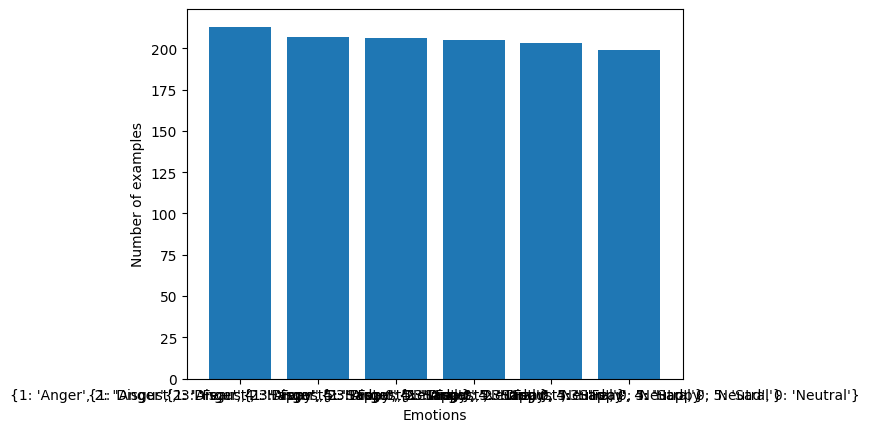

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(6), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(6))
ax.set_xticklabels([EMOTIONS for i in range(6)],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

# Load the signals

In [4]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 33/1233 files

/tmp/ipykernel_34/2624433725.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Processed 228/1233 files

/tmp/ipykernel_34/2624433725.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


 Processed 1232/1233 files

In [5]:
emotion_ind = list(data.loc[data.Emotion==EMOTIONS,'Emotion'].index)
emotion_ind = np.random.permutation(emotion_ind)

In [6]:
emotion_ind = list(data.loc[data.Emotion==EMOTIONS,'Emotion'].index.astype(int))

# Split the data

In [7]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)].astype(int)
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)].astype(int)
    ind_test = emotion_ind[int(0.9*m):].astype(int)
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(984, 48000), Y_train:(984,)
X_val:(123, 48000), Y_val:(123,)
X_test:(126, 48000), Y_test:(126,)
Number of unique indexes is 1233, out of 1233


# Augment signals by adding AWGN

In [8]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [9]:
import pandas as pd
import numpy as np

aug_signals = []
aug_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(data.loc[i,"Emotion"])
        aug_signals.append(augmented_signals[j,:])
        # Correct the concatenation here
        data = pd.concat([data, data.iloc[[i]]], ignore_index=True)
    print("\r Processed {}/{} files".format(i+1,X_train.shape[0]), end='')

aug_signals = np.stack(aug_signals, axis=0)
X_train = np.concatenate([X_train, aug_signals], axis=0)
aug_labels = np.array(aug_labels)  # Convert to numpy array
Y_train = np.concatenate([Y_train, aug_labels])

print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')

 Processed 984/984 files
X_train:(2952, 48000), Y_train:(2952,)


# Calculate mel spectrograms

MEL spectrogram shape:  (128, 188)


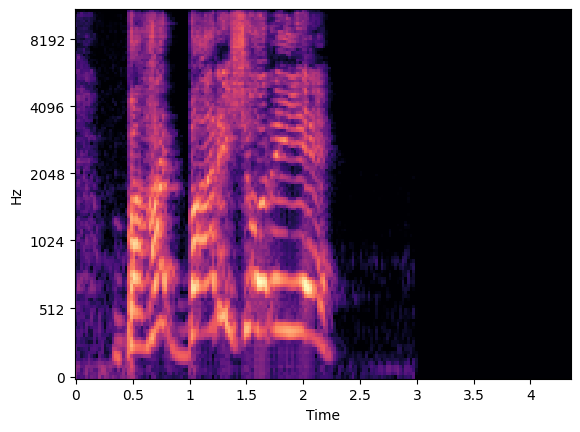

In [10]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[1,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [11]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train,axis=0)
del X_train
X_train = mel_train

mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val

mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

Calculatin mel spectrograms for train set
 Processed 2951/2952 files
Calculatin mel spectrograms for val set
 Processed 122/123 files
Calculatin mel spectrograms for test set
 Processed 125/126 files
X_train:(2952, 128, 188), Y_train:(2952,)
X_val:(123, 128, 188), Y_val:(123,)
X_test:(126, 128, 188), Y_test:(126,)


# Create the model

In [32]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self, num_emotions, input_shape=(1, 128, 188)):
        super().__init__()
        # conv block (keep this as it is)
        self.conv2Dblock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)

        )
        
        # Calculate the output size of the conv block
        with torch.no_grad():
            sample_input = torch.zeros(1, *input_shape)
            conv_output = self.conv2Dblock(sample_input)
            self.conv_output_size = conv_output.numel()
        
        # LSTM block
        self.transf_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        transf_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=512, dropout=0.4, activation='relu')
        self.transf_encoder = nn.TransformerEncoder(transf_layer, num_layers=4)
        
        # Calculate the output size of the transformer
        transf_input_size = (input_shape[1] // 2) * (input_shape[2] // 4)  # after maxpool
        self.transf_output_size = 64  # d_model of the transformer
        
        # Calculate total input size for the linear layer
        total_features = self.conv_output_size + self.transf_output_size
        
        # Linear softmax layer
        self.out_linear = nn.Linear(total_features, num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1)
        
        # transformer embedding
        x_reduced = self.transf_maxpool(x)
        x_reduced = torch.squeeze(x_reduced, 1)
        x_reduced = x_reduced.permute(0, 2, 1)  # (b, t, freq)
        transf_out = self.transf_encoder(x_reduced)
        transf_embedding = torch.mean(transf_out, dim=1)
        
        # concatenate
        complete_embedding = torch.cat([conv_embedding, transf_embedding], dim=1)
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, None

# Usage
model = ParallelModel(num_emotions=6, input_shape=(1, 128, 188))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [33]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# TRAINING

In [34]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [35]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [36]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_val, and X_test are your original data
# and they have shape (batch_size, height, width)

# Add channel dimension if it's not already present
X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

# Now they should have shape (batch_size, channels, height, width)

scaler = StandardScaler()

# Reshape and scale
b, c, h, w = X_train.shape
X_train = np.reshape(X_train, newshape=(b, -1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b, c, h, w))

b, c, h, w = X_test.shape
X_test = np.reshape(X_test, newshape=(b, -1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b, c, h, w))

b, c, h, w = X_val.shape
X_val = np.reshape(X_val, newshape=(b, -1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b, c, h, w))

ValueError: too many values to unpack (expected 4)

In [37]:
# Remove one of the extra dimensions
X_train = np.squeeze(X_train, axis=1)
X_val = np.squeeze(X_val, axis=1)
X_test = np.squeeze(X_test, axis=1)

# Now they should have shape (batch_size, channels, height, width)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2952, 1, 128, 188)
X_val shape: (123, 1, 128, 188)
X_test shape: (126, 1, 128, 188)


Train the model

In [41]:
EPOCHS = 150
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ', sum(p.numel() for p in model.parameters()))
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model, loss_fnc)
losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Shuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end - batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X, device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)
        loss, acc = train_step(X_tensor, Y_tensor)
        epoch_acc += acc * actual_batch_size / DATASET_SIZE
        epoch_loss += loss * actual_batch_size / DATASET_SIZE
    
    X_val_tensor = torch.tensor(X_val, device=device).float()
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.long, device=device)
    val_loss, val_acc, _ = validate(X_val_tensor, Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

Selected device is cuda
Number of trainable params:  393382
Epoch 1/150 --> loss:1.7080, acc:26.56%, val_loss:1.8608, val_acc:20.33%
Epoch 2/150 --> loss:1.5858, acc:30.89%, val_loss:2.0032, val_acc:24.39%
Epoch 3/150 --> loss:1.5126, acc:33.81%, val_loss:1.6585, val_acc:33.33%
Epoch 4/150 --> loss:1.4920, acc:34.65%, val_loss:1.7349, val_acc:30.89%
Epoch 5/150 --> loss:1.4611, acc:37.20%, val_loss:1.6412, val_acc:35.77%
Epoch 6/150 --> loss:1.4530, acc:36.99%, val_loss:1.6759, val_acc:30.89%
Epoch 7/150 --> loss:1.4413, acc:39.26%, val_loss:1.5344, val_acc:37.40%
Epoch 8/150 --> loss:1.4051, acc:39.53%, val_loss:1.5778, val_acc:33.33%
Epoch 9/150 --> loss:1.3949, acc:39.97%, val_loss:1.5461, val_acc:36.59%
Epoch 10/150 --> loss:1.3758, acc:40.45%, val_loss:1.4611, val_acc:39.84%
Epoch 11/150 --> loss:1.3604, acc:42.11%, val_loss:1.4164, val_acc:43.09%
Epoch 12/150 --> loss:1.3429, acc:42.65%, val_loss:1.4148, val_acc:39.84%
Epoch 13/150 --> loss:1.3166, acc:43.67%, val_loss:1.5761, va

# Save model

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt')))

# Load model

In [ ]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))

# Test

In [42]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 1.151
Test accuracy is 63.49%


# Plot loss

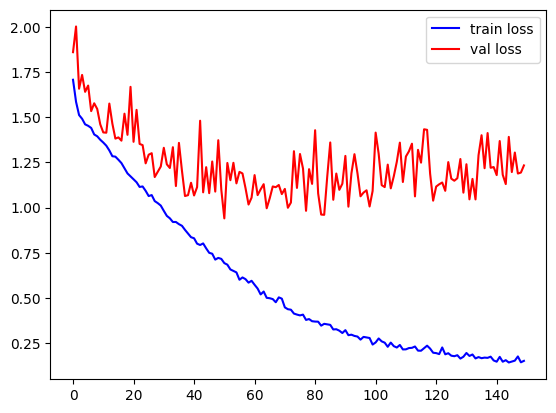

In [43]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

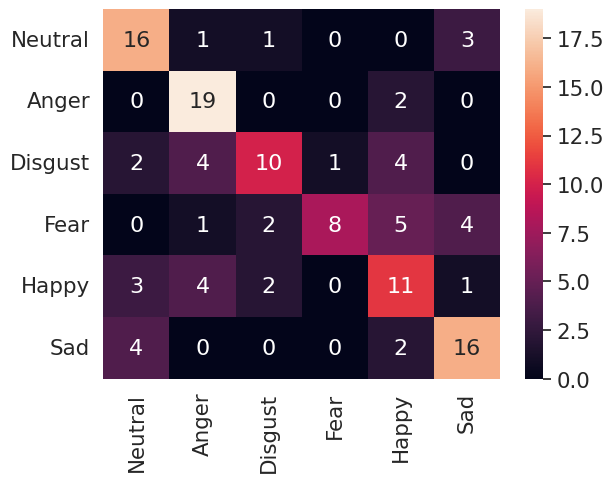

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()